In [1]:
from pandas import Series, read_csv, DataFrame
import random
import matplotlib.pyplot as plt

from generateTestingData.useGeneratedData import makeDataUsable
from geneticAlgorithms.geneticAlgorithm import GeneticAlgorithm
from geneticAlgorithms.useGeneticAlgorithm import printSols
from main.generateTestingData.useGeneratedData import NewPredicter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Extracing relevant features from solutions
def getRelevantDataFromIndividuals(individuals):
    return [ind[1][:16] for ind in individuals]

In [3]:
def findBestMatch(rank, individual, data, minVals, maxVals):
    rowIndex = -1
    bestScore = 99999
    for i, row in data.iterrows():
        score = 0
        for colIndex, (val, c, min, max) in enumerate(zip(individual, row, minVals, maxVals)):
            if colIndex > 7 and colIndex < 12:
                continue
            score += abs(c-val)/(max-min)*100
        if bestScore > score:
            rowIndex = i
            bestScore = score
    return rank, rowIndex, bestScore

In [4]:
def findAllMatches(individuals, data, removeRows=True):
    matches = []
    data = data[data.columns[:-1]].copy()
    minVals = data.min()
    maxVals = data.max()
    amount = len(individuals)
    for rank, individual in enumerate(individuals):
        matches.append(findBestMatch(rank, individual, data, minVals, maxVals))
        if removeRows:
            data.drop(matches[-1][1], inplace=True)
        if (rank+1) % 100 == 0:
            print(f"Found a match for {rank+1} out of {amount} individuals", end="\r")
    print()
    print("Found a match for all individuals.")
    return matches

In [5]:
# Find the score of genetic algorithm
def accuracy(matches, data):
    percent = [5,10,25,50,100]
    for p in percent:
        amount = int(p/100 * len(matches))
        correct = 0
        for _, rowIndex, _ in matches[:amount]:
            correct += data.loc[rowIndex]["COL"]
        print(f"Accuracy for top {p}% individuals from GA:".ljust(42), correct/amount, f"\t{int(correct)} out of {amount}")

# accuracy(allMatches)

# Loading data

In [6]:
comparingData = makeDataUsable(read_csv("../data/generatedData.csv"), 4, 5)
comparingData.drop(columns=comparingData.columns[17:-1], axis=1, inplace=True)
comparingData.drop(columns=comparingData.columns[0], axis=1, inplace=True)
# comparingData = comparingData.loc[comparingData['COL'] == 1]
print(f"Number of rows: {len(comparingData)}")
display(comparingData.head())

Number of rows: 3950


,TTC1,TTC2,TTC3,TTC4,DTO1,DTO2,DTO3,DTO4,JERK1,JERK2,JERK3,JERK4,Speed1,Speed2,Speed3,Speed4,COL
0,50.0,50.0,50.0,50.000,16.6264,100.0,100.0,100.0000,0.004,0.661,4.117,0.865,2.881,0.661,5.439,11.082,0.0
1,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,0.661,4.117,0.865,3.704,0.661,5.439,11.082,13.021,0.0
2,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,4.117,0.865,3.704,2.233,5.439,11.082,13.021,12.727,0.0
3,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,0.865,3.704,2.233,0.009,11.082,13.021,12.727,12.442,0.0
4,50.0,50.0,50.0,5.322,100.0000,100.0,100.0,83.3296,3.704,2.233,0.009,2.308,13.021,12.727,12.442,14.465,0.0


# Generating individuals from the genetic algorithm

In [7]:
# # random.seed(51)
# ga = GeneticAlgorithm(populationLimit=5000,
# 						maxGenerations=700,
# 						tmParticipants=3,
# 						variation=5,
# 						mutationChance=0.4,
# 						fitnessGoal = 1000,
# 						toKeep=2)
    
# individuals = ga.run()

In [9]:
def plotEvolution(history, saveFig, filename):
    sizes = {
        "figureSize" : (15,8),
        "font_xs" : 5,
        "font_s" : 10,
        "font_m" : 15,
        "font_l" : 20,
        "lines" : 3
    }
    # plt.subplot(121)
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    color1 = "coral"
    color2 = "royalblue"

    ax.plot(history["generation"],  history["best"],  color=color1, linewidth=sizes["lines"])
    ax.set_ylabel("Best fitness", color=color1, fontsize=sizes["font_m"])

    ax2.plot(history["generation"], history["average"], color=color2, )
    ax2.set_ylabel("Average fitness", color=color2, fontsize=sizes["font_m"])

    ax.set_xlabel("Generation", fontsize = sizes["font_m"])

    plt.title(f"Evolution of the genetic algorithm", fontsize=sizes["font_l"])
    plt.xticks(fontsize=sizes["font_s"])
    plt.yticks(fontsize=sizes["font_s"])
    plt.show()

    fig, ax = plt.subplots()
    # ax2 = ax.twinx()

    color1 = "coral"
    color2 = "royalblue"

    ax.plot(history["generation"],  history["average"],  color=color1, linewidth=sizes["lines"], label="average")
    # ax.set_ylabel("Average fitness", color=color1, fontsize=sizes["font_m"])

    ax.plot(history["generation"], history["averageTop20"], color=color2, label="averageTop20")
    # ax.set_ylabel("Top 20 average fitness", color=color2, fontsize=sizes["font_m"])

    ax.set_xlabel("Generation", fontsize = sizes["font_m"])
    ax.set_ylabel("Fitness", fontsize = 14)

    plt.title(f"Evolution of the genetic algorithm", fontsize=sizes["font_l"])
    plt.xticks(fontsize=sizes["font_s"])
    plt.yticks(fontsize=sizes["font_s"])
    plt.legend()

    if saveFig:
        plt.savefig(f"../data/figures/{filename}")
    plt.show()

# ga.plotEvolution(False, "")
# plotEvolution(ga.history, False, "")

# Running GA multiple time to generate more fit individuals

In [10]:
# RUN GA multiple times
gaList = []
CombinedIndividuals = []
for i in range(5):
    print(f"\n Run number: {i}")
    gaList.append(GeneticAlgorithm(populationLimit=1000,
						maxGenerations=1000,
						tmParticipants=3,
						variation=5,
						mutationChance=0.4,
						fitnessGoal = 1000,
						toKeep=2))
    generatedIndividuals = gaList[i].run()
    
    CombinedIndividuals += [generatedIndividuals]


 Run number: 0
=== Gen 0 best individual ===
	Fitness: 0.11729634      Values: (16.432478320586682, 0.48279768154378644, 22.933867842864192, 13.320241248370891, 43.60980417730372, 7.361691244939834, 95.8929116981305, 92.84988951661178, 44.00282491389833, 3.0946816250607725, 27.030342242932186, 44.82886108073174, 4.413890868745341, 14.34149339436975, 4.4293149939614835, 6.8034397859863205, 0.5745470802719578, 1.0748093955765567, 0.22838316520329072, 0.4173462818294262, -0.9607420982612624, 0.8629692323616643, -1.0371186425321048, 1.2699036250591351, -0.8549751727369868, -1.2599645753305266, -0.1767416678779773, -0.36432595374921595)
=== Gen 100 best individual ===
	Fitness: 3.43952268      Values: (6.687440993237672, 3.385127174173377, 3.6179510696637394, 3.393867118953068, 27.66884295898322, 10.303030760794442, 9.149514045158938, 9.323931109337124, 70.46649608556918, 33.70835294448942, 16.192359764726973, 24.88647445782162, 4.171573242483081, 2.7809547115303275, 2.419149296137448, 2.7

In [13]:
for individuals in CombinedIndividuals:
    print(len(individuals))

1000
1000
1000
1000
1000


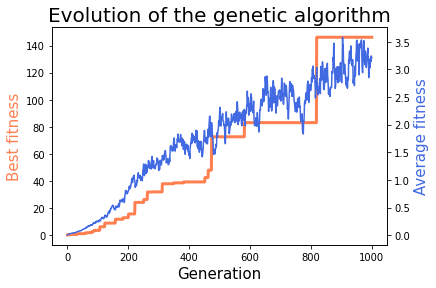

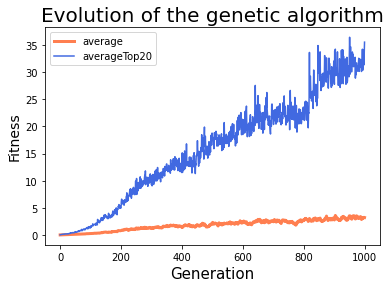

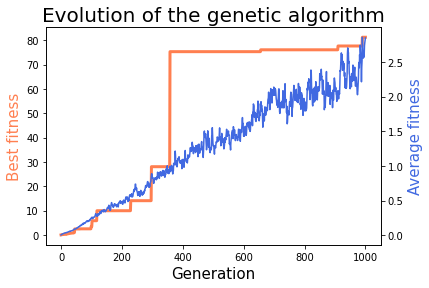

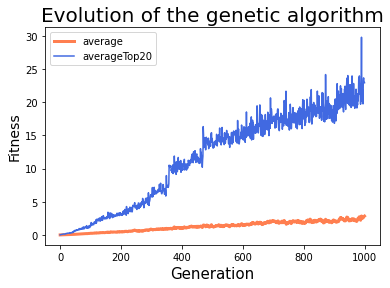

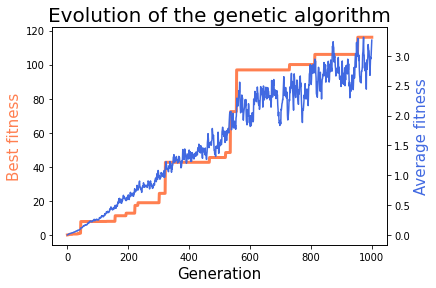

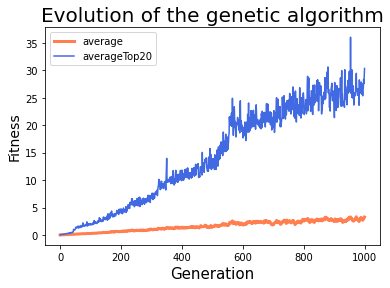

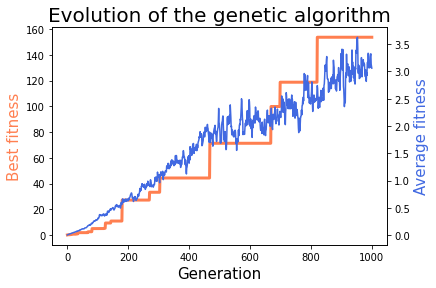

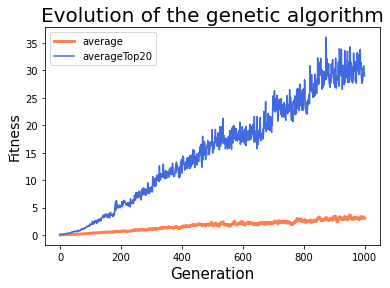

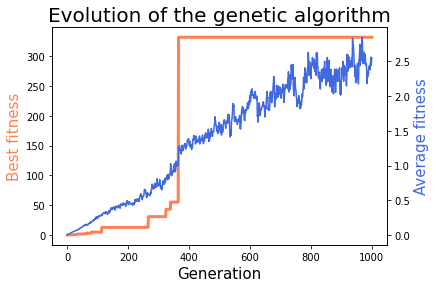

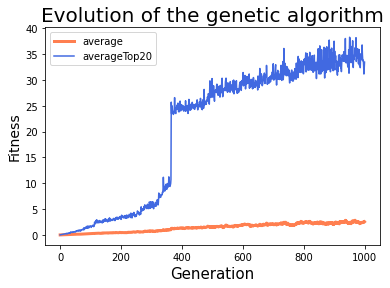

In [59]:
for ga in gaList:
    plotEvolution(ga.history, False, "")
# plotEvolution(gaList[4].history, False, "")

In [15]:
def printSols(solutions):
    numberOfEach = 4
    colsToUse = ["TTCs", "DTOs", "JERKs", "Speeds"] #, "asX", "asY", "asZ"]
    print()

    ttc = 0
    dto = 4
    jerk = 8
    speeds = 12
    for values in solutions:
        print(f"Score: {round(values[0], 4)}".ljust(17), end=" ")
        for i in range(0, len(colsToUse)*4, len(colsToUse)):
            if (i) % 4 == 0:
                s = colsToUse[(i) // len(colsToUse)]
            vals = [round(v, 3) for v in values[1][i:i+numberOfEach]]
            print(f"{s}: {vals}".ljust(40), end=" ")
        print()


def individualsToCSV(combinedIndividuals, topN=10):
    cols = ["Score","TTC1","TTC2","TTC3","TTC4","DTO1","DTO2","DTO3","DTO4",
            "JERK1","JERK2","JERK3","JERK4","Speed1","Speed2","Speed3","Speed4",
            "asX1","asX2","asX3","asX4","asY1","asY2","asY3","asY4","asZ1","asZ2","asZ3","asZ4"]
    d = {col: [] for col in cols}
    for individuals in combinedIndividuals:
        for score, values in individuals[:topN]:
            d["Score"].append(score)
            for c, val in zip(cols[1:], values):
                d[c].append(val)
            
    df = DataFrame(d)
    display(df.head())
    
    df.to_csv("../data/combinedDataGA", index=False)

topN = 20
individualsToCSV(CombinedIndividuals, topN)

,Score,TTC1,TTC2,TTC3,TTC4,DTO1,DTO2,DTO3,DTO4,JERK1,...,asX3,asX4,asY1,asY2,asY3,asY4,asZ1,asZ2,asZ3,asZ4
0,146.126816,6.103584,3.177847,3.549037,3.408111,22.492807,10.362424,10.400825,8.926813,44.707065,...,-0.390549,-0.326136,0.731962,-1.353540,-1.295164,-1.221379,0.546498,-1.538765,0.392054,0.491704
1,139.532903,6.178635,3.177847,3.522572,3.438038,22.618354,10.282562,10.087754,8.754189,6.473424,...,-0.282146,-0.273933,-1.123973,0.476346,0.887841,-1.345222,0.824478,-1.171697,-0.366254,0.615331
2,60.130840,6.178635,3.162782,3.549037,3.408111,22.492807,10.362424,10.244369,8.926813,44.707065,...,-0.390549,0.078185,0.731962,-0.615343,0.981461,-1.221379,0.546498,-1.538765,0.392054,-0.316499
3,53.426621,6.103584,3.177847,3.597511,3.368576,22.688053,10.326690,10.223100,8.755939,78.701955,...,0.045394,0.473280,0.731962,-0.230186,-0.121456,-1.221379,-1.143215,-0.795993,-0.238793,0.103172
4,31.071112,6.103584,3.151805,3.549037,3.357693,22.656521,10.326690,10.042749,8.733112,42.291089,...,-0.282146,0.247549,0.829993,1.277637,0.651693,-1.200554,-1.449832,-1.391459,-0.268425,0.103172


# Predicting if the individuals can lead to a collision
* 1 = Collision
* 0 = not a collision

In [14]:
modelsGen = [
    "MLPClassifier_gen_PI4_RBC5_75-34-22-68",
    "RandomForestClassifier_gen_PI4_RBC5_82-34-15-68",
    "SVC_gen_PI4_RBC5_82-38-15-64",
    "XGBClassifier_gen_PI4_RBC5_82-15-27-75"
]


def getPredsFromGA(models, filename):
    data = read_csv(filename)
    predictions = {}
    clfs = []
    for model in models:
        clfs.append(NewPredicter.loadModel(model))
        predictions[model] = []

    for _, row in data.iterrows():
        for i, model in enumerate(predictions):
            m = clfs[i]
            p = m.predict(m.preProcess(row.to_list()[1:]))[0]
            predictions[model].append(p)
    print()
    for model, preds in predictions.items():
        print(model[:model.find("_")].ljust(25), int(sum(preds)),  "out of", len(preds))

    return predictions

predsGA = getPredsFromGA(modelsGen, "../data/combinedDataGA")
# predsGA = getPredsFromGA(modelsFromPoster, "../data/combinedDataGA")


Model loaded!
Model loaded!
Model loaded!
Model loaded!

MLPClassifier             56 out of 100
RandomForestClassifier    55 out of 100
SVC                       0 out of 100
XGBClassifier             19 out of 100


# Finding best matching row for each
Checking if the row could be an actual collision.

The highest ranking individual gets the first pick, the row is then excluded from available rows.

In [21]:
# relIndividuals = []
allMatches = []
for individuals in CombinedIndividuals:
    relIndividuals = getRelevantDataFromIndividuals(individuals[:topN])
    allMatches.append(findAllMatches(relIndividuals, comparingData, removeRows=True))
    # break


Found a match for all individuals.

Found a match for all individuals.

Found a match for all individuals.

Found a match for all individuals.

Found a match for all individuals.


In [38]:
matchesDict = {"run": [], "rank": [], "row": [], "score": [], "isCollision": []}

for i, matches in enumerate(allMatches):
    for rank, row, score in matches:
        score = round(score, 3)
        # print(f"Rank: {rank}".ljust(12) + f"Best matching row: {row}".ljust(27) + f"Score: {score}".ljust(18) + f"The row is a collision: {bool(comparingData.loc[[row]]['COL'].values[0])}")
        matchesDict["run"].append(i)
        matchesDict["rank"].append(rank)
        matchesDict["row"].append(row)
        matchesDict["score"].append(score)
        matchesDict["isCollision"].append(bool(comparingData.loc[[row]]['COL'].values[0]))
        # rounded = [round(val, 1) for val in individuals[rank][1]]
        # print(rounded[:16])
        # display(comparingData.loc[[row]])
matchesDF = DataFrame(matchesDict)
matchesDF.head()
    

,run,rank,row,score,isCollision
0,0,0,1257,35.239,False
1,0,1,3284,37.568,False
2,0,2,3285,37.325,False
3,0,3,4000,39.116,True
4,0,4,377,47.575,False


In [49]:
for i in range(5):
    # for id, row in matchesDF.loc[matchesDF["run"]==i].iterrows():
    #     print(row)
    a = matchesDF.loc[matchesDF["run"]==i]
    # print(a)
    print(f'Amount col: {len(a[a["isCollision"] == True])}, Avg score: {round(a[a["isCollision"] == True]["score"].mean(), 3)}, {len(a[a["isCollision"] == False])}, Avg score: {round(a[a["isCollision"] == False]["score"].mean(), 3)}')
    # break

Amount col: 6, Avg score: 60.848, 14, Avg score: 59.521
Amount col: 9, Avg score: 54.74, 11, Avg score: 60.329
Amount col: 9, Avg score: 59.21, 11, Avg score: 55.95
Amount col: 8, Avg score: 52.644, 12, Avg score: 58.938
Amount col: 10, Avg score: 53.321, 10, Avg score: 52.123


In [21]:
printSols(individuals[:3])
display(comparingData.loc[[2406]])


Score: 253.929    TTCs: [3.475, 3.758, 4.49, 2.94]         DTOs: [13.727, 14.935, 12.957, 8.198]    JERKs: [46.883, 81.187, 82.239, 2.181]   Speeds: [4.312, 4.293, 2.858, 2.928]     
Score: 213.195    TTCs: [3.394, 3.676, 4.398, 2.981]       DTOs: [13.797, 15.1, 12.857, 8.365]      JERKs: [75.418, 10.823, 15.791, 49.278]  Speeds: [4.481, 4.473, 2.913, 2.947]     
Score: 61.95      TTCs: [3.394, 3.717, 4.428, 2.992]       DTOs: [13.676, 14.948, 12.972, 8.32]     JERKs: [86.657, 42.178, 3.189, 33.464]   Speeds: [4.418, 4.359, 2.926, 2.91]      


,TTC1,TTC2,TTC3,TTC4,DTO1,DTO2,DTO3,DTO4,JERK1,JERK2,JERK3,JERK4,Speed1,Speed2,Speed3,Speed4,COL
2406,2.711,2.083,1.33,0.848,21.986,17.4271,12.6846,7.9954,0.008,6.348,6.42,0.004,8.025,9.529,9.428,9.328,1.0


In [22]:
dto = [3.951, 23.629, 4.417, 4.819]
a = [21.986,17.4271,12.6846,7.9954]
ttc = [0.686, 1.969, 0.826, 0.753]

def calTTC(d0, d1):
    return 0.5 * (d1/(d0-d1))

for i in range(1,4):
    print(f"{calTTC(a[i-1], a[i])}")

1.9113272938647474
1.337332630469162
0.8525334811908215


# Calculates the accuracy for the matches

In [51]:
for i, matches in enumerate(allMatches):
    print(f"\nFrom run {i}")
    accuracy(matches, comparingData)


From run 0
Accuracy for top 5% individuals from GA:   0.0 	0 out of 1
Accuracy for top 10% individuals from GA:  0.0 	0 out of 2
Accuracy for top 25% individuals from GA:  0.2 	1 out of 5
Accuracy for top 50% individuals from GA:  0.4 	4 out of 10
Accuracy for top 100% individuals from GA: 0.3 	6 out of 20

From run 1
Accuracy for top 5% individuals from GA:   1.0 	1 out of 1
Accuracy for top 10% individuals from GA:  0.5 	1 out of 2
Accuracy for top 25% individuals from GA:  0.6 	3 out of 5
Accuracy for top 50% individuals from GA:  0.5 	5 out of 10
Accuracy for top 100% individuals from GA: 0.45 	9 out of 20

From run 2
Accuracy for top 5% individuals from GA:   1.0 	1 out of 1
Accuracy for top 10% individuals from GA:  0.5 	1 out of 2
Accuracy for top 25% individuals from GA:  0.4 	2 out of 5
Accuracy for top 50% individuals from GA:  0.3 	3 out of 10
Accuracy for top 100% individuals from GA: 0.45 	9 out of 20

From run 3
Accuracy for top 5% individuals from GA:   1.0 	1 out of 1
